# Regression Trees and Model Optimization - Lab

## Introduction

In this final lab, we'll see how to apply regression analysis using CART trees for regression while making use of some hyperparameter tuning to improve our model. For a comparison of predictive capabilities and computational cost, we'll work the "Boston Housing" dataset. This will allow us to compare different regression approaches in terms of their accuracy and cost involved. 

## Objectives
You will be able to:
- Apply predictive regression analysis with CART trees
- Get the data ready for modeling
- Tune the key hyper parameters based a various models developed during training 
- Study the impact of tree pruning on the quality of predictions

## Boston Housing Dataset - Again ! 

The dataset is available in the repo as `boston.csv`. 

- Load the Dataset and print its head and dimensions

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
# import pydotplus

In [2]:
data = pd.read_csv('boston.csv')

data.shape

(506, 15)

In [3]:
data.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Identify Features and Target Data
In this lab, we'll use three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. You'll find a brief description of each predictor below:

#### Features
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.

#### Target
- `MEDV`', the median value of the home. 


- Create dataframes for features and target as shown above. 
- Inspect the contents for validity 

In [4]:
features = data[['rm', 'lstat', 'ptratio']]
target = data['medv']

In [5]:
data.medv.describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

In [6]:
features.describe()

,rm,lstat,ptratio
count,506.000000,506.000000,506.000000
mean,6.284634,12.653063,18.455534
std,0.702617,7.141062,2.164946
min,3.561000,1.730000,12.600000
25%,5.885500,6.950000,17.400000
50%,6.208500,11.360000,19.050000
75%,6.623500,16.955000,20.200000
max,8.780000,37.970000,22.000000


## Inspect Correlations 

- Use scatter plots to show the correlation between chosen features and target variable
- Comment on each scatter plot 

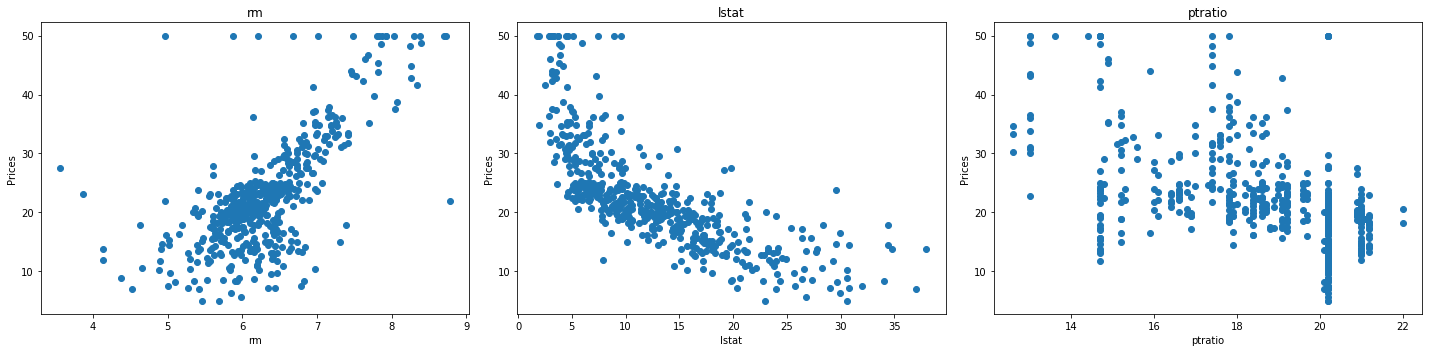

In [7]:
plt.figure(figsize=(20, 5))
for i, col in enumerate(features.columns):
    plt.subplot(1, 3, i+1)
    plt.plot(data[col], target, 'o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Prices')
    plt.tight_layout()

There is a clear positive relationship between rooms and price. As rooms increase, price increases.

There is a negative relationship between lstat and price. As lstat increases, price decreases.

Ptratio has alot of noise, but may have a slight negative relationship with price.


## Create Evaluation Metrics

- Create a function `performance(true, predicted)` to calculate and return the r-sqaured score and MSE for two equal sized arrays showing true and predicted values
- TEst the function with given data 

In [8]:
# Evaluation Metrics
# Import metrics

def performance(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    r2 = r2_score(y_true, y_predict)
    mse = mean_squared_error(y_true, y_predict)
    
    return [r2, mse]

# Calculate the performance - TEST
score = performance([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
score

# [0.9228556485355649, 0.4719999999999998]

[0.9228556485355649, 0.4719999999999998]

## Supervised Training 
- For supervised learning, split the `features` and `target` datasets into training/test data (80/20). 
- For reproducibility, use `random_state=42`

In [9]:
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42)

## Grow a Vanilla Regression Tree

- Run a baseline model for later comparison using the datasets created above
- Generate predictions for test dataset and calculate the performance measures using the function created above.
- Use `random_state=45` for tree instance
- Record your observations

In [10]:
regressor = DecisionTreeRegressor(random_state=45)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
score = performance(y_test, y_pred)
score[0], score[1]

# (0.4712438851035674, 38.7756862745098)  - R2, MSE

(0.47097115950374013, 38.795686274509805)

An r-squared of 0.47 is very poor performance. 

A mean squared error of almost 39 is also very poor, given that price only has a range of 5 to 50.

## Hyperparameter Tuning 

- Find the best tree depth for a depth range: 1-30
- Run the regressor repeatedly in a for loop for each depth value. 
- Use `random_state=45` for reproducibility
- Calculate MSE and r-squared for each run 
- Plot both performance measures, for all runs.
- Comment on the output 

In [11]:
max_depths = np.linspace(1, 30, 30, endpoint=True)
mse_results = []
r2_results = []

for max_depth in max_depths:
    regressor = DecisionTreeRegressor(max_depth=max_depth, random_state=45)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    score = performance(y_test, y_pred)
    r2_results.append(score[0])
    mse_results.append(score[1])

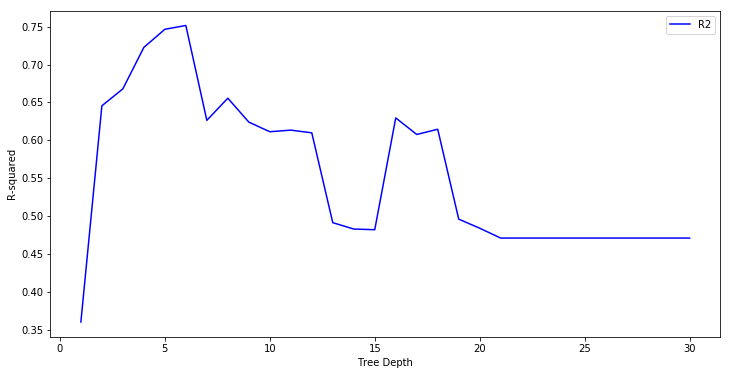

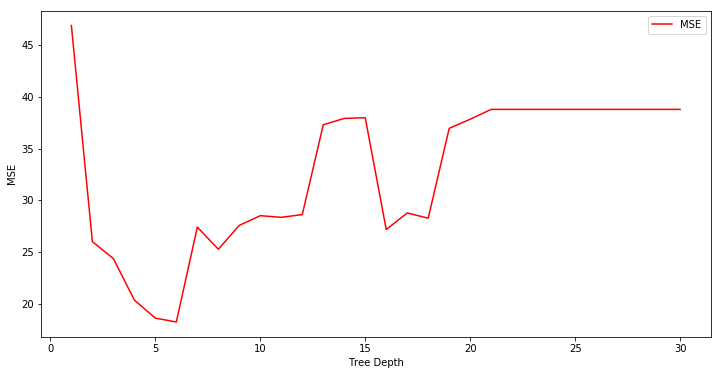

In [12]:
plt.figure(figsize=(12,6))
plt.plot(max_depths, r2_results, 'b', label='R2')
plt.xlabel('Tree Depth')
plt.ylabel('R-squared')
plt.legend()

plt.figure(figsize=(12,6))
plt.plot(max_depths, mse_results, 'r', label='MSE')
plt.xlabel('Tree Depth')
plt.ylabel('MSE')
plt.legend()

The highest r-squared and the lowest MSE both seem to occur at a tree depth of 6.

## More Hyperparameter Tuning 

- Repeat the above process for `min_samples_split` parameter

- Use a a range of values from 2-10 for this parameter 
- Use `random_state=45` for reproducibility
- Visualize the output and comment on results as above

In [13]:
min_samples_splits = np.arange(2,11)
mse_results = []
r2_results = []

for min_samples_split in min_samples_splits:
    regressor = DecisionTreeRegressor(min_samples_split=int(min_samples_split), random_state=45)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    score = performance(y_test, y_pred)
    r2_results.append(score[0])
    mse_results.append(score[1])

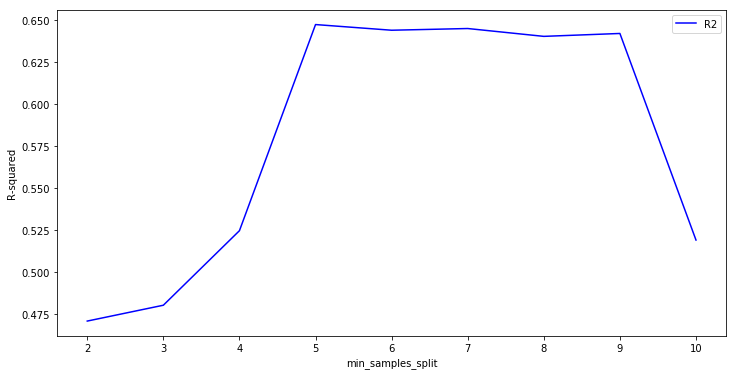

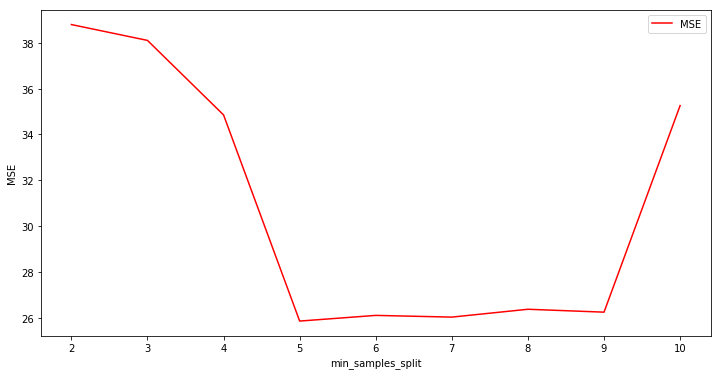

In [14]:
plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, r2_results, 'b', label='R2')
plt.xlabel('min_samples_split')
plt.ylabel('R-squared')
plt.legend()

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, mse_results, 'r', label='MSE')
plt.xlabel('min_samples_split')
plt.ylabel('MSE')
plt.legend()

# QUESTION FOR MEETING WITH JEFF
The best value for min)samples_split appears to be from 5 to 9.
Solution says:
We can say that 6(or 7) are the optimal values as its not advisable to choose border values (like 5 or 9) - Ask Jeff why.

# Run the "Optimized" Model 

- Use the best values for max_depth and min_samples_split found in previous runs and run an optimized model with these values. 
- Calculate the performance and comment on the output 

In [18]:
max_depth = 6
min_samples_split = 7

regressor = DecisionTreeRegressor(
    min_samples_split=min_samples_split, max_depth=max_depth, random_state=45)

regressor

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=7, min_weight_fraction_leaf=0.0,
           presort=False, random_state=45, splitter='best')

In [19]:
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

In [20]:
score = performance(y_test, y_pred)
score[0], score[1]

(0.7517202710143275, 18.20729180853906)

Pretty signifigant improvement. Likely can be further improved by using more features and by tuing the hyperparameters further.

# Visualize the tree
* Visualize the trained model as we did in previous sections
* Show the labels for each variable being split in a node
* Interpret the tree

In [21]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(regressor, out_file=dot_data, filled=True, rounded=True,special_characters=True, feature_names=features.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

ModuleNotFoundError: No module named 'pydotplus'

## Level Up - Optional 

- How about bringing in some more features from the original dataset which may be good predictors?
- Also , try tuning more hyperparameters like `max-features` to find the optimal version of the model. 


## Summary 

In this lab, we looked at applying a decision tree based regression analysis on the Boston Housing Dataset. We saw how to train various models to find the optimal values for pruning and limiting the growth of the trees. We also looked at how to extract some rules from visualizing trees , that might be used for decision making later. 